<a href="https://colab.research.google.com/github/HarisAhamed/final-project/blob/main/final_project_customer_conversion_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement
You are working for a new-age insurance company and employ mutiple outreach plans to sell term insurance to your customers. Telephonic marketing campaigns still remain one of the most effective way to reach out to people however they incur a lot of cost. Hence, it is important to identify the customers that are most likely to convert beforehand so that they can be specifically targeted via call. We are given the historical marketing data of the insurance company and are required to build a ML model that will predict if a client will subscribe to the insurance.

# Features:
age (numeric)

job : type of job

marital : marital status

educational_qual : education status

call_type : contact communication type

day: last contact day of the month (numeric)

mon: last contact month of year

dur: last contact duration, in seconds (numeric)

num_calls: number of contacts performed during this campaign and for this client

prev_outcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

Output variable (desired target):
y - has the client subscribed to the insurance?



# 1.Importing Libraries and Loading Dataset

In [95]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score,confusion_matrix

from imblearn.combine import SMOTETomek

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# mounting drive
from google.colab import drive
drive.mount('/content/drive')

# loading the dataset from the path
path = '/content/drive/MyDrive/customer_conversion_prediction.csv'
df=pd.read_csv(path,error_bad_lines=False)
print('shape of the data:', df .shape)
df .head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
shape of the data: (57648, 11)


<ipython-input-95-38d550efb50a>:32: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df=pd.read_csv(path,error_bad_lines=False)
Skipping line 16499: expected 11 fields, saw 20



,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y
0,58,management,married,tertiary,unknown,5,may,261,1,unknown,no
1,44,technician,single,secondary,unknown,5,may,151,1,unknown,no
2,33,entrepreneur,married,secondary,unknown,5,may,76,1,unknown,no
3,47,blue-collar,married,unknown,unknown,5,may,92,1,unknown,no
4,33,unknown,single,unknown,unknown,5,may,198,1,unknown,no


# 2.Data cleaning
Checking the data types of all the columns

In [96]:
df.dtypes

age                int64
job               object
marital           object
education_qual    object
call_type         object
day                int64
mon               object
dur                int64
num_calls          int64
prev_outcome      object
y                 object
dtype: object

In [97]:
df.isnull().sum()           # looking for the amount of null data in the pandas dataframe

age               0
job               0
marital           0
education_qual    0
call_type         0
day               0
mon               0
dur               0
num_calls         0
prev_outcome      0
y                 0
dtype: int64

In [98]:
df.duplicated().sum()       # finding the duplicates to drop

12444

In [99]:
df.drop_duplicates()        # duplicated values are dropped
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57648 entries, 0 to 57647
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             57648 non-null  int64 
 1   job             57648 non-null  object
 2   marital         57648 non-null  object
 3   education_qual  57648 non-null  object
 4   call_type       57648 non-null  object
 5   day             57648 non-null  int64 
 6   mon             57648 non-null  object
 7   dur             57648 non-null  int64 
 8   num_calls       57648 non-null  int64 
 9   prev_outcome    57648 non-null  object
 10  y               57648 non-null  object
dtypes: int64(4), object(7)
memory usage: 4.8+ MB


In [100]:
df.describe()               # statistically cheking any outlires present or not

,age,day,dur,num_calls
count,57648.000000,57648.000000,57648.000000,57648.000000
mean,40.867610,15.412573,260.120594,2.619848
std,11.147196,8.204516,254.394870,2.858770
min,18.000000,1.000000,0.000000,1.000000
25%,32.000000,8.000000,105.000000,1.000000
50%,39.000000,15.000000,184.000000,2.000000
75%,48.000000,21.000000,323.000000,3.000000
max,95.000000,31.000000,4918.000000,63.000000


# 3. Exploratory Data Analysis

In [103]:
df["y"].value_counts()

no     49056
yes     8592
Name: y, dtype: int64

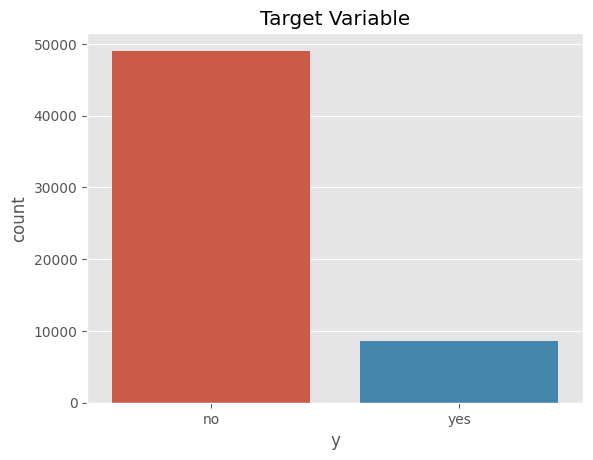

In [64]:
sns.countplot(x="y", data=df)
plt.title("Target Variable")
plt.show()

finding percentage of No and Yes

In [65]:
# percentage of class present in target variable(y)
print("percentage of NO and YES\n",df["y"].value_counts()/len(df)*100)

percentage of NO and YES
 no     85.095754
yes    14.904246
Name: y, dtype: float64


The class distribution in the target variable is 85:15 indicating an imbalance dataset

## univariate analysis of categorical variables

Index(['job', 'marital', 'education_qual', 'call_type', 'mon', 'prev_outcome',
       'y'],
      dtype='object')


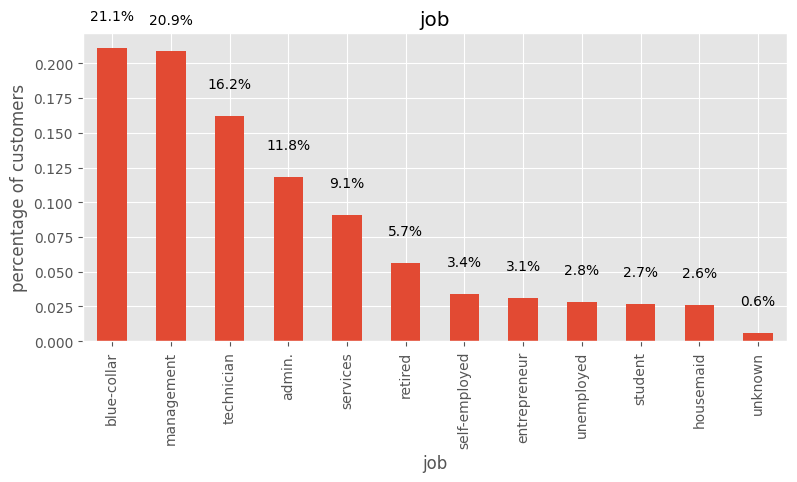

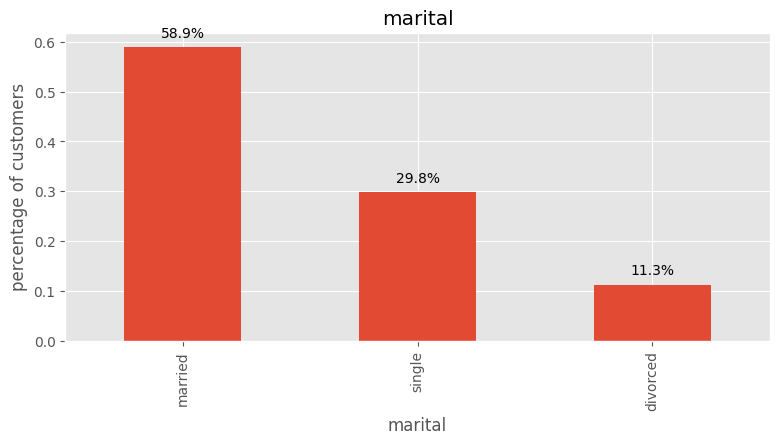

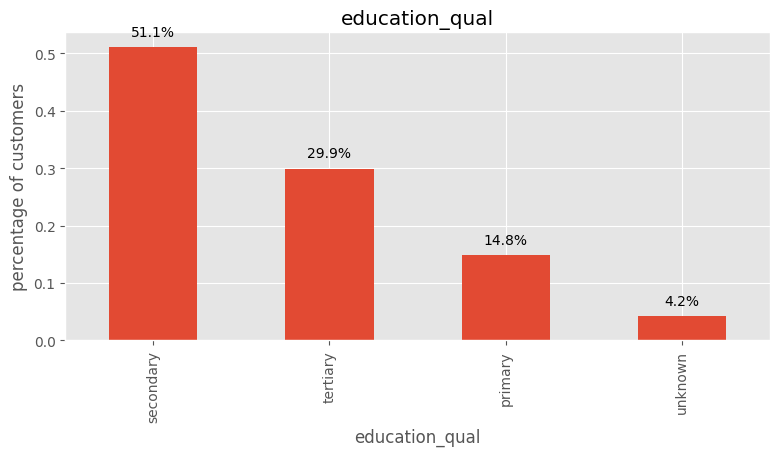

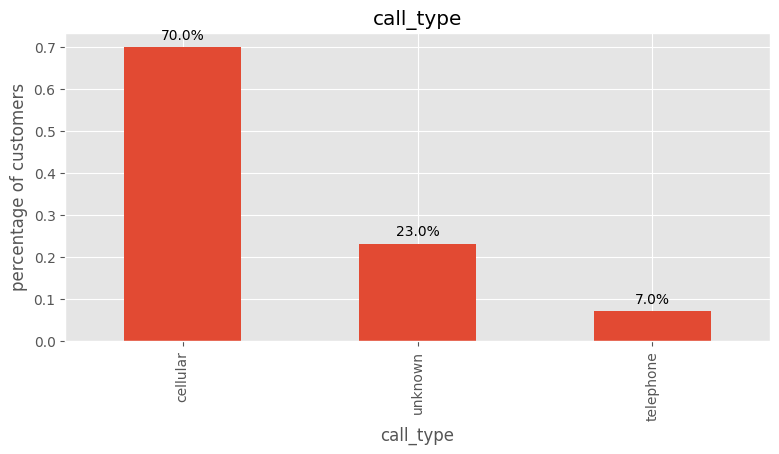

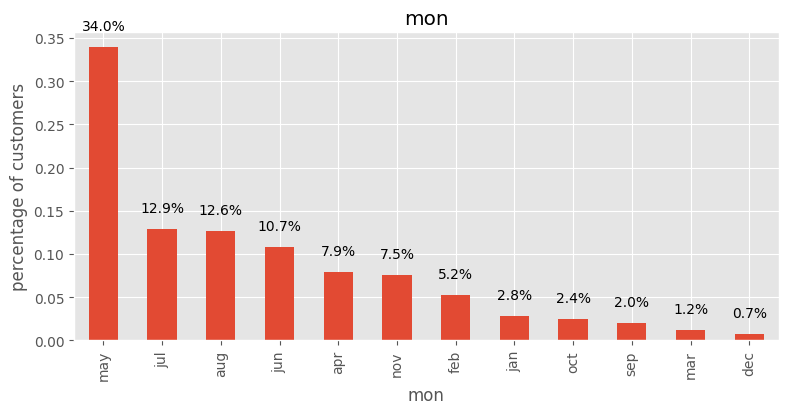

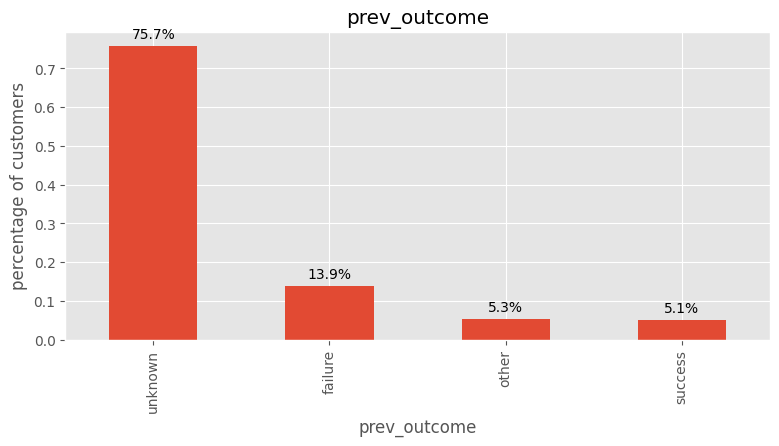

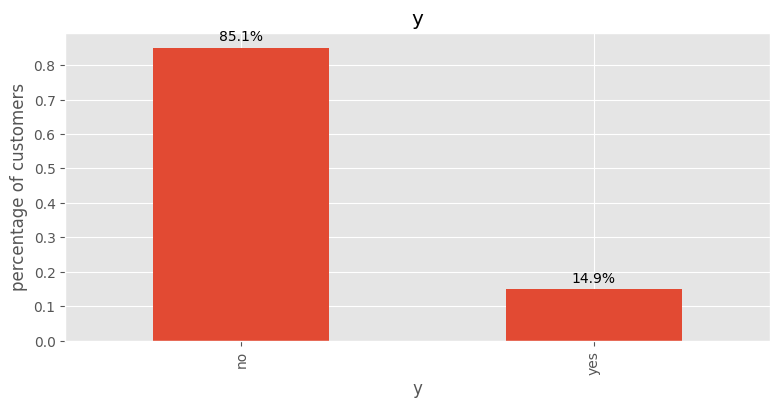

In [66]:
# indentifying the categorical variables

cat_variable= df.select_dtypes(include= ["object"]).columns
print(cat_variable)

# plotting bar chart for each categorical variable
plt.style.use("ggplot")

for column in cat_variable:
    plt.figure(figsize=(20,4))
    ax = plt.subplot(121)
    df[column].value_counts(normalize=True).plot(kind="bar")
    plt.xlabel(column)
    plt.ylabel("percentage of customers")
    plt.title(column)

    # Add percentage labels to the top of each bar
    for p in ax.patches:
        ax.text(p.get_x()+p.get_width()/2., p.get_height()+0.02, f"{p.get_height()*100:.1f}%", ha="center")

### Observations :

* The top three professions that our customers belong to are -Management , blue-collar jobs and technicians.

* A huge number of the customers are married.

* Cellular type is most used by customers.

* Many customers have been contacted in the month of May.

* Very less number of customers are there who succeessfully converted previously

* Most of customers are belong to secondary education qualification

* The plot for the target variable shows heavy imbalance in the target variable.

* The missing values in some columns have been represented as unknown. unknown represents missing data.

In [67]:
cat_variable1=['job','education_qual']
for column in cat_variable1:
    mode= df[column].mode()[0]
    df[column]= df[column].replace("unknown", mode)

### Univariate analysis of Numerical columns

In [68]:
num_variable= df.select_dtypes(include=np.number)
num_variable.head()

,age,day,dur,num_calls
0,58,5,261,1
1,44,5,151,1
2,33,5,76,1
3,47,5,92,1
4,33,5,198,1


<ipython-input-69-c9f537584757>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], kde=True)
<ipython-input-69-c9f537584757>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], kde=True)
<ipython-input-69-c9f537584757>:6: UserWarning: 

`distplot` is a deprecated function and 

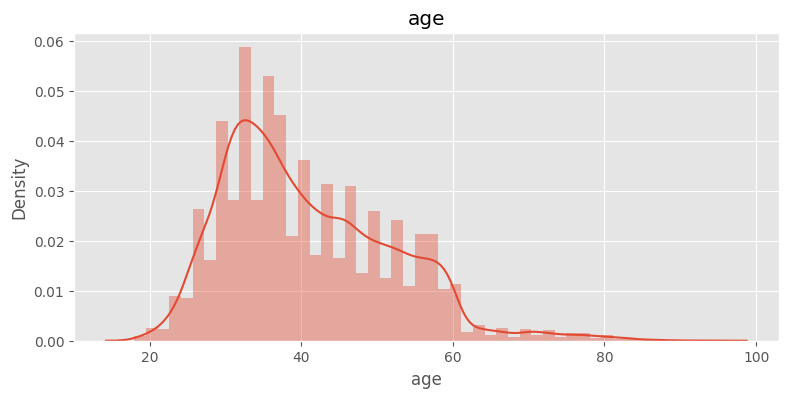

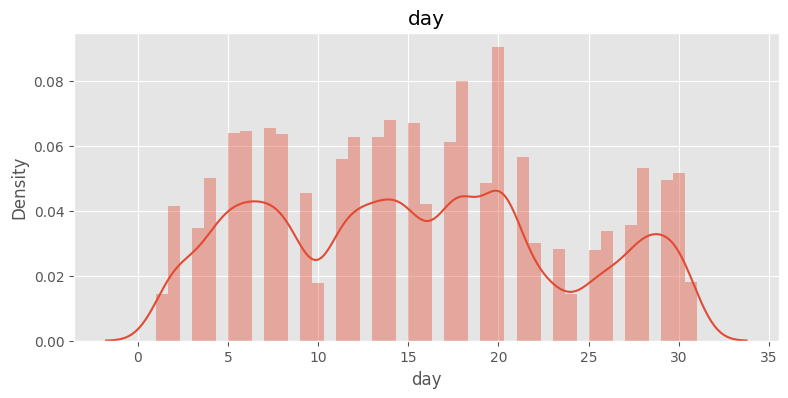

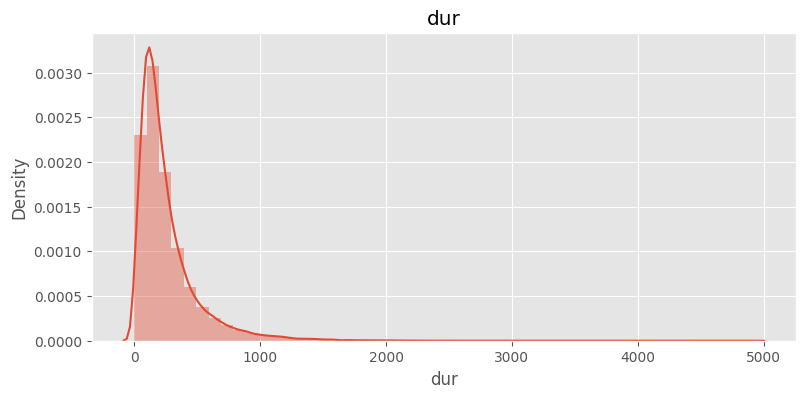

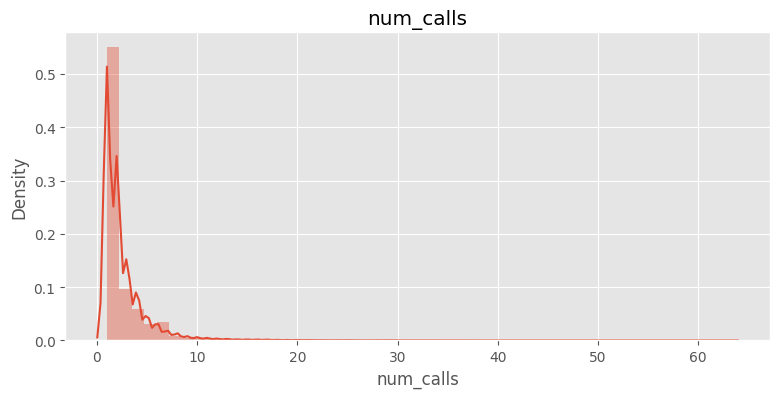

In [69]:
# plotting histogram for each numerical variable
plt.style.use("ggplot")
for column in ["age", "day", "dur",'num_calls']:
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    sns.distplot(df[column], kde=True)
    plt.title(column)

### Observation :

The histogram reveals heavily skewed features like age, dur, and num_calls due to outliers. The boxplot for num_calls suggests most customers were contacted for the first or second time.

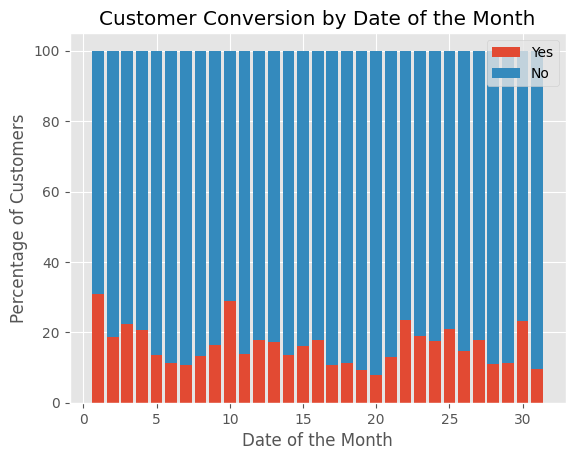

In [70]:
day_counts = df.groupby('day')['y'].value_counts(normalize=True) * 100
yes_counts = day_counts[:, 'yes']
no_counts = day_counts[:, 'no']

plt.bar(day_counts.index.levels[0], yes_counts, label='Yes')
plt.bar(day_counts.index.levels[0], no_counts, bottom=yes_counts, label='No')
plt.xlabel('Date of the Month')
plt.ylabel('Percentage of Customers')
plt.title('Customer Conversion by Date of the Month')
plt.legend()
plt.show()

### Observation :

from above plot we can see 1,3,4,10,22,25,30 dates are when customer said yes most

## Bivariate Analysis of Categorical Columns

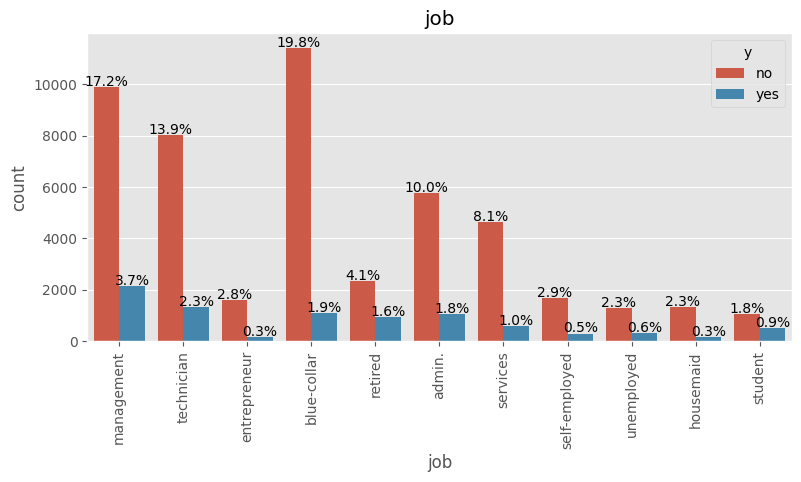

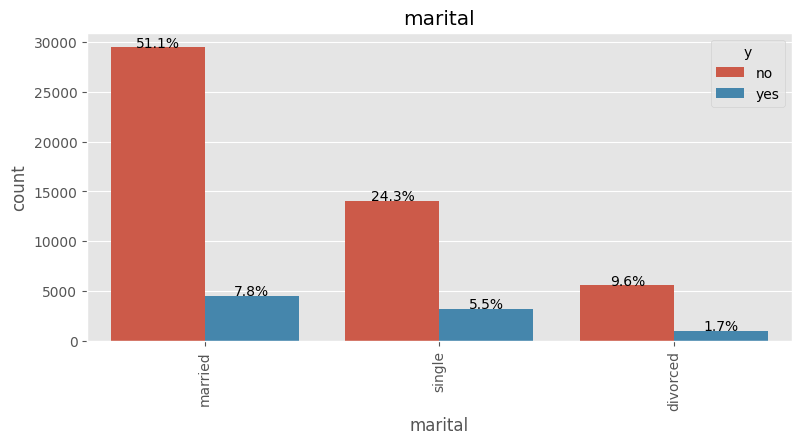

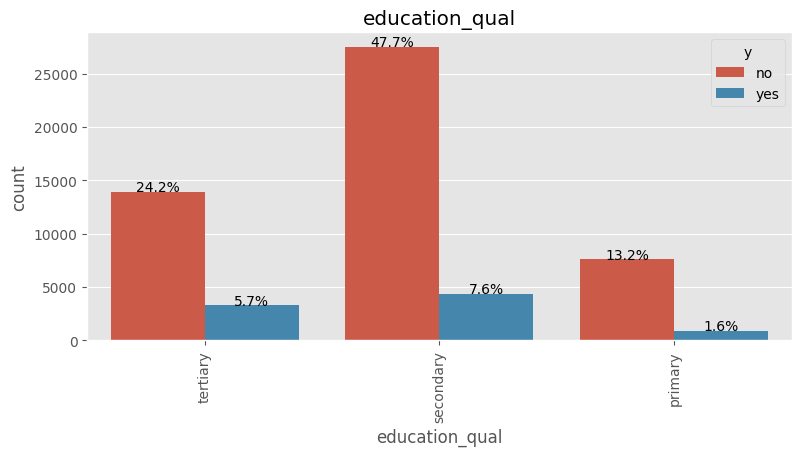

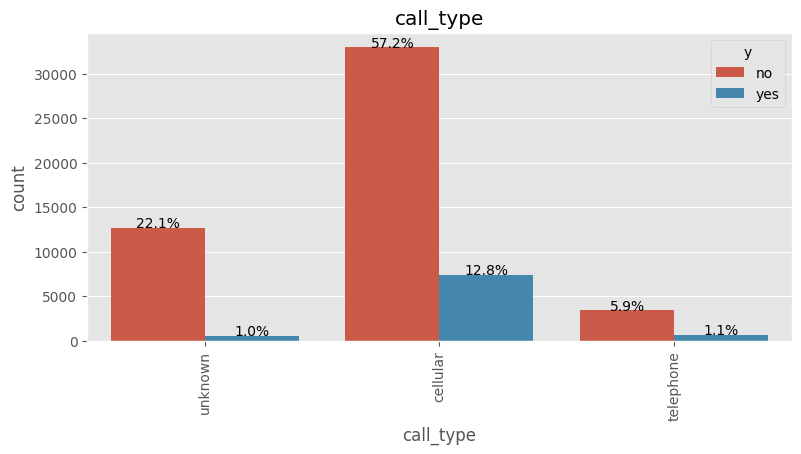

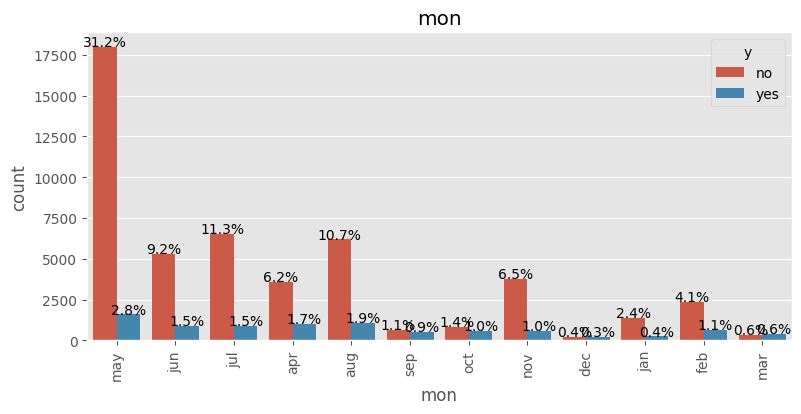

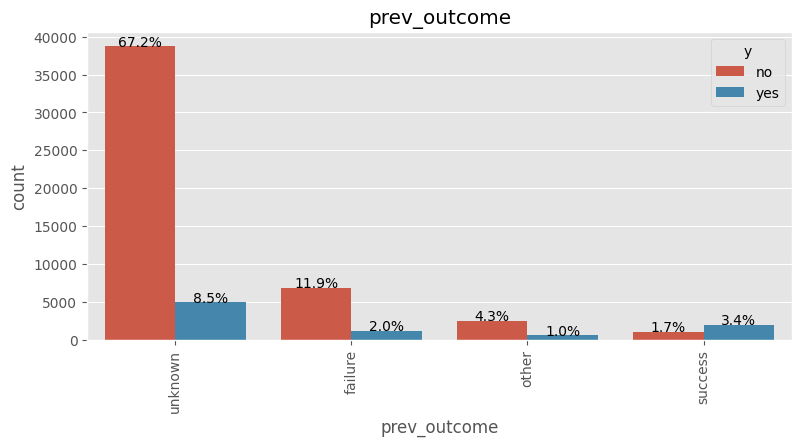

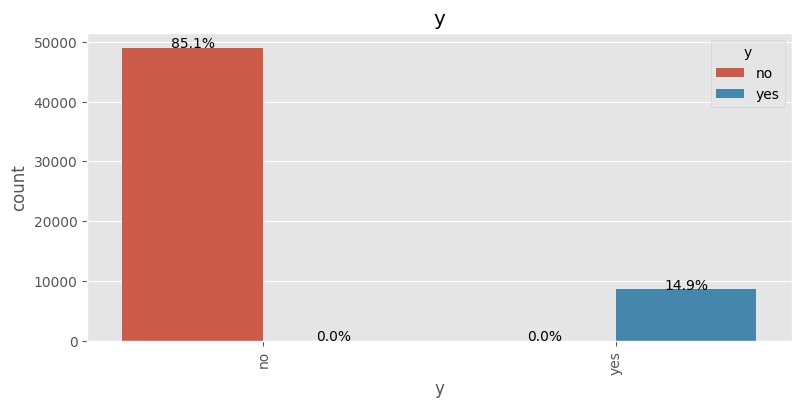

In [71]:
plt.style.use("ggplot")

for column in cat_var:
    plt.figure(figsize=(20,4))
    ax = plt.subplot(121)
    sns.countplot(x=column, hue="y", data=df)
    plt.title(column)
    plt.xticks(rotation=90)

    # Add percentage labels to the top of each bar
    for p in ax.patches:
        height = p.get_height()
        total = sum([p.get_height() for p in ax.patches if p.get_x() == p.get_x()])
        ax.text(p.get_x()+p.get_width()/2., height+50, f"{height/total*100:.1f}%", ha="center")

    plt.show()

### Observations:

* Customers having management jobs form the majority among those who have converted most.

* Married, most of them converted

* Secondary education qualified are converted most

* Cell phones should be the preferred mode of contact for contacting customers.

* May should be the preferred month to contact

### Outliers significantly affect the Mean and Variance, making it crucial to treat them.

In [72]:
df.describe()

,age,day,dur,num_calls
count,57648.000000,57648.000000,57648.000000,57648.000000
mean,40.867610,15.412573,260.120594,2.619848
std,11.147196,8.204516,254.394870,2.858770
min,18.000000,1.000000,0.000000,1.000000
25%,32.000000,8.000000,105.000000,1.000000
50%,39.000000,15.000000,184.000000,2.000000
75%,48.000000,21.000000,323.000000,3.000000
max,95.000000,31.000000,4918.000000,63.000000


compute the interquantile range to calculate the boundaries.

In [73]:
lower_boundries= []
upper_boundries= []
for i in ["age", "dur", "day","num_calls"]:
    IQR= df[i].quantile(0.75) - df[i].quantile(0.25)
    lower_bound= df[i].quantile(0.25) - (1.5*IQR)
    upper_bound= df[i].quantile(0.75) + (1.5*IQR)

    print(i, ":", lower_bound, ",",  upper_bound)

    lower_boundries.append(lower_bound)
    upper_boundries.append(upper_bound)

age : 8.0 , 72.0
dur : -222.0 , 650.0
day : -11.5 , 40.5
num_calls : -2.0 , 6.0


In [74]:
# replace the all the outliers which is greater then upper boundary
j = 0
for i in ["age", "dur", "day","num_calls"]:
    df.loc[df[i] > upper_boundries[j], i] = int(upper_boundries[j])
    j = j + 1

**The lower boundary values for age, dur_num_calls, and day are negative, so replacing outliers with the lower boundary is not necessary.**

In [75]:
df.describe()

,age,day,dur,num_calls
count,57648.000000,57648.000000,57648.000000,57648.000000
mean,40.789394,15.412573,238.056238,2.314634
std,10.892908,8.204516,177.804541,1.560653
min,18.000000,1.000000,0.000000,1.000000
25%,32.000000,8.000000,105.000000,1.000000
50%,39.000000,15.000000,184.000000,2.000000
75%,48.000000,21.000000,323.000000,3.000000
max,72.000000,31.000000,650.000000,6.000000


**The maximum values were altered without affecting other parameters like mean, standard deviation, or quartiles after replacing outliers with the upper boundary.**

# Encoding Categorical Features

<ipython-input-76-defe37030ca1>:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


<Axes: >

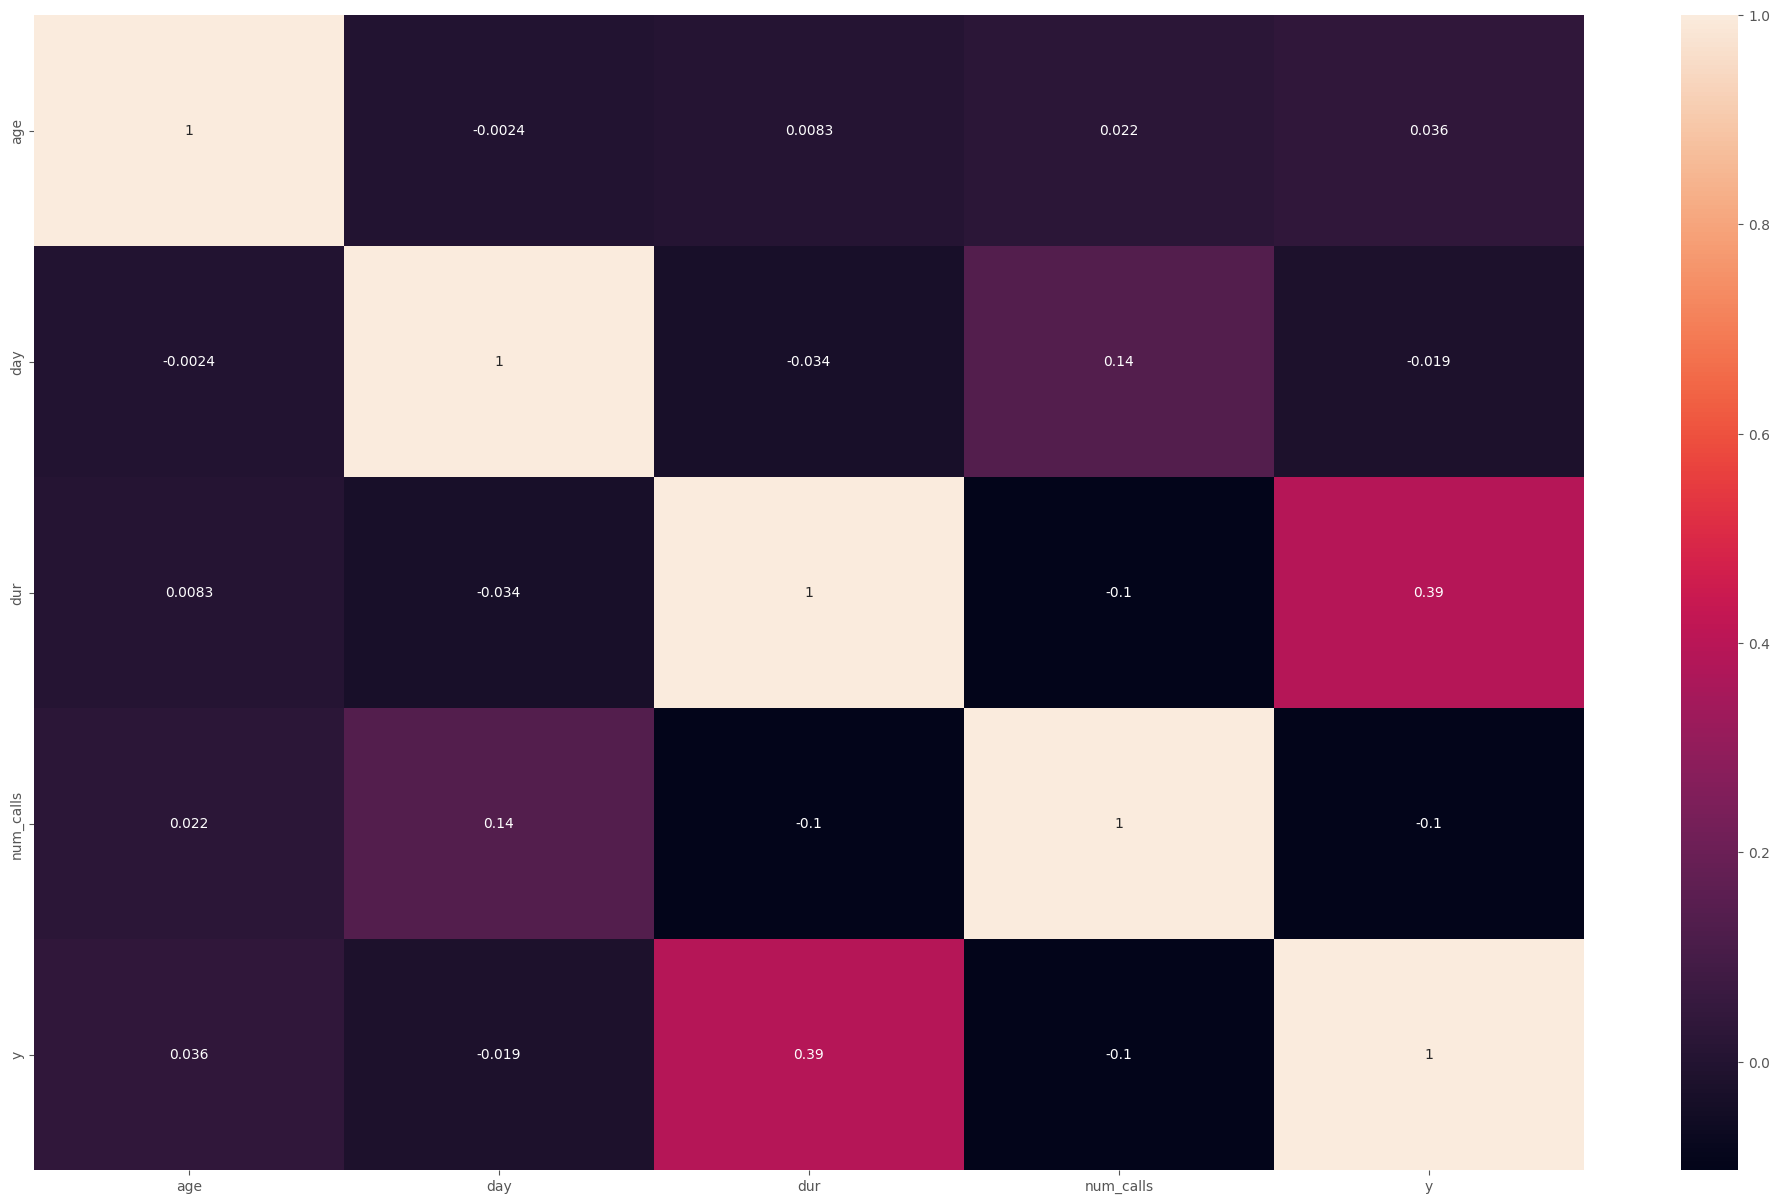

In [76]:
#'y'  target variable
df.replace({'y' : { 'yes' : 1, 'no' : 0}},inplace=True)



plt.figure(figsize=(25,15))
sns.heatmap(df.corr(), annot=True)

In [77]:
cat_variable= df.select_dtypes(include= ["object"]).columns
print(cat_variable)

Index(['job', 'marital', 'education_qual', 'call_type', 'mon', 'prev_outcome'], dtype='object')


In [78]:
for i in cat_variable:
    print(i, ":", df[i].unique())

job : ['management' 'technician' 'entrepreneur' 'blue-collar' 'retired' 'admin.'
 'services' 'self-employed' 'unemployed' 'housemaid' 'student']
marital : ['married' 'single' 'divorced']
education_qual : ['tertiary' 'secondary' 'primary']
call_type : ['unknown' 'cellular' 'telephone']
mon : ['may' 'jun' 'jul' 'apr' 'aug' 'sep' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar']
prev_outcome : ['unknown' 'failure' 'other' 'success']


In [79]:
def encoding_data(df,col):
  for i in col:
     df_dummies = pd.get_dummies(df[i], prefix=i)
     df = pd.concat([df, df_dummies], axis=1)
     df.drop([i],inplace=True,axis=1)
  return df

In [80]:
columns=['call_type','prev_outcome','marital','job']
df=encoding_data(df,columns)


In [81]:
# Months column
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

df['mon'] = df['mon'].apply(
    lambda x: months.index(x)+1
)

In [82]:
# education_qual column
df.replace({'education_qual' : { 'tertiary' : 1, 'secondary' : 2, 'primary' : 3 }},inplace=True)

# 5.Spliting the Data

In [83]:
p= df.drop(['y'],axis=1)
q= df['y']

Since the class distribution in the target variable is 85:15 indicating an imbalance dataset, we need to resample it

**SMOTE** **Oversampling** we are using due to imbalence data

In [84]:
# Define the SMOTETomek object with a 0.75 sampling strategy
smote_tomek = SMOTETomek(sampling_strategy=0.75)

# Apply SMOTETomek oversampling to the training data
X, y = smote_tomek.fit_resample(p, q)

# Check the class distribution of the resampled data
print(y.value_counts())

0    48828
1    36564
Name: y, dtype: int64


In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# 6.Scaling
### Scaling the data

In [86]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 7.Building Machine Learning Model

### 1.Logistic regression

In [87]:
lr_model = LogisticRegression(max_iter=100)
lr_model.fit(X_train, y_train)
predicted=lr_model.predict(X_test)
conf = confusion_matrix(y_test, predicted)

print()
print()
print ("The accuracy of Logistic Regression is : ", accuracy_score(y_test, predicted)*100, "%")
print ("The aurroc_auc_score of Logistic Regression is : ", roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1]))
log_reg_y_pred_prob = lr_model.predict_proba(X_test)[:, 1]
log_reg_auc = roc_auc_score(y_test, log_reg_y_pred_prob)



The accuracy of Logistic Regression is :  88.22924059616749 %
The aurroc_auc_score of Logistic Regression is :  0.9519779139088148


### 2.Random forest

In [88]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train, y_train)
predicted = rf_model.predict(X_test)
print("The accuracy of Random Forest is : ", accuracy_score(y_test, predicted.round())*100, "%")
print ("The aurroc_auc_score of  random forest is : ", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))
dt_y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_y_pred_prob)
dt_auc = roc_auc_score(y_test, dt_y_pred_prob)

The accuracy of Random Forest is :  96.28459900638751 %
The aurroc_auc_score of  random forest is :  0.9934691378867925


### 3.XGBOOST

In [89]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False)
xgb_model.fit(X_train, y_train)
predicted = xgb_model.predict(X_test)

print()
print ("The accuracy of X Gradient Boosting is : ", accuracy_score(y_test, predicted)*100, "%")
print ("The aurroc_auc_score of Gradient Boosting is : ", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]))
xgb_y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_y_pred_prob)


The accuracy of X Gradient Boosting is :  92.43435060326473 %
The aurroc_auc_score of Gradient Boosting is :  0.9807688962860039


### 7.Feature Importance

<Axes: >

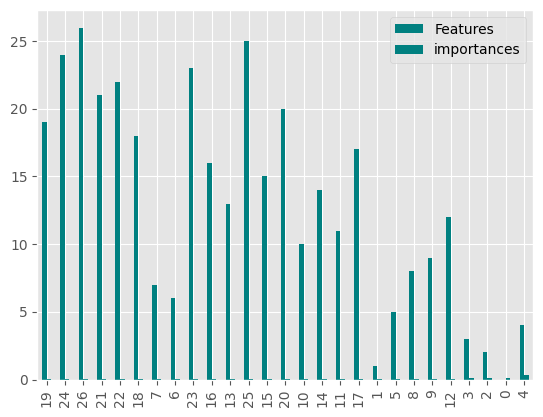

In [90]:
importances = rf_model.feature_importances_
df1 = pd.DataFrame({"Features":pd.DataFrame(X_test).columns,"importances":importances})
df1.set_index("importances")

df1 = df1.sort_values('importances')
df1.plot.bar(color='teal')

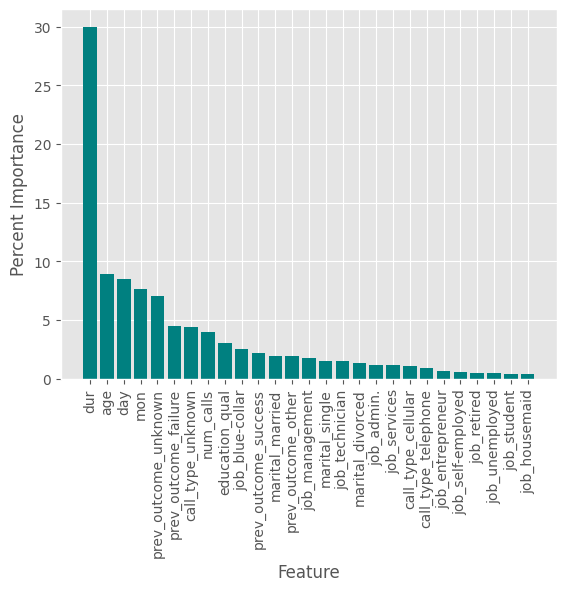

In [91]:
feature_names = list(df.columns)
if 'y' in feature_names:
    feature_names.remove('y')
total_importance = importances.sum()
percent_importances = importances / total_importance * 100

# Create a DataFrame with the feature names and their percent importances
df = pd.DataFrame({'feature_names': feature_names, 'percent_importances': percent_importances})

# Sort the DataFrame by percent importances in descending order
df = df.sort_values(by='percent_importances', ascending=False)

# Create a bar plot of the percent importances
plt.bar(x=df['feature_names'], height=df['percent_importances'], color='teal')
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Percent Importance')
plt.show()

### Most important feature is duration

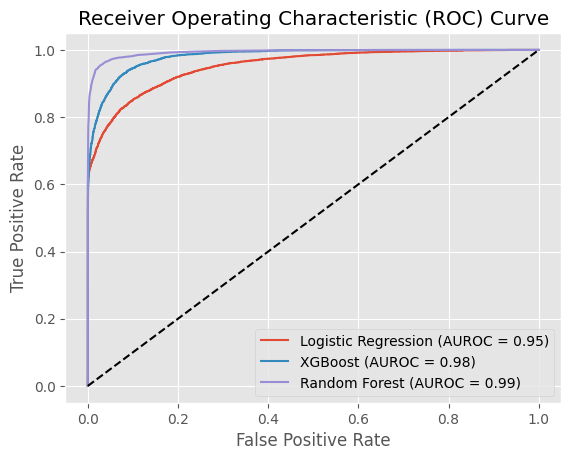

In [92]:
log_reg_fpr, log_reg_tpr, _ = roc_curve(y_test, log_reg_y_pred_prob)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_y_pred_prob)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_y_pred_prob)

# Plot ROC curves
plt.plot(log_reg_fpr, log_reg_tpr, label=f'Logistic Regression (AUROC = {log_reg_auc:.2f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUROC = {xgb_auc:.2f})')
plt.plot(dt_fpr, dt_tpr, label=f'Random Forest (AUROC = {dt_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Conclusion
The evaluation of three classification models (Logistic Regression, XGBoost, and Random Forest) on historical data showed Random Forest as the most accurate with a 96.28% accuracy score and the highest AUROC score of 0.993.
This suggests Random Forest is suitable for predicting insurance subscriptions and optimizing marketing costs.